In [6]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
file_path = '/content/drive/My Drive/Colab Notebooks/cleaned_training_data.csv'  ##cleaned training dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
data = pd.read_csv(file_path,  header=0)

In [6]:
y = data['bad_flag'].astype(float)
X = data.drop(columns=['bad_flag'])

## split the dataset into traing, validation and test part

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.10, random_state=1000
)

In [8]:
X_t, X_val, y_t, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.20, random_state=1000
)

In [9]:
from sklearn.utils import resample

train_data = pd.concat([X_t, y_t], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['bad_flag'] == 0]
minority_class = train_data[train_data['bad_flag'] == 1]

# Determine the target size for the majority class
majority_target_size = len(minority_class) * 5  # Set to *1 for equal size

# Subsample majority class
majority_class_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=majority_target_size,
    random_state=42
)

# Combine the subsampled majority class with the minority class
balanced_data = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the combined dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back into features and target
X_train_balanced = balanced_data.drop(columns=['bad_flag'])
y_train_balanced = balanced_data['bad_flag']

### I tried both oversmaple with smote and subsample, the results shows both have low precision and F1 score, but subsample method has higher recall, finally I use subsample

In [11]:
# smote = SMOTE(sampling_strategy=0.1, random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_t, y_t)

In [10]:
X_train_smote, y_train_smote = X_train_balanced, y_train_balanced

In [11]:
numer = ['term', 'int_rate', 'emp_length', 'annual_inc', 'percent_bc_gt_75',
        'dti', 'inq_last_6mths', 'mths_since_recent_inq',
       'total_bc_limit', 'tot_cur_bal', 'internal_score']
dummy = X_train.columns.difference(numer)

In [12]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_smote[numer])
X_val_num_scaled = scaler.transform(X_val[numer])

In [13]:
X_train_scaled1 = pd.DataFrame(X_train_num_scaled, columns=numer, index=X_train_smote.index)
X_train_scaled = pd.concat([X_train_scaled1, X_train_smote[dummy]], axis=1)

X_val_scaled1 = pd.DataFrame(X_val_num_scaled, columns=numer, index=X_val.index)
X_val_scaled = pd.concat([X_val_scaled1, X_val[dummy]], axis=1)

In [14]:

print(y_train_smote.value_counts())

bad_flag
0.0    47260
1.0     9452
Name: count, dtype: int64


In [15]:
print(y_val.value_counts())

bad_flag
0.0    31740
1.0     2363
Name: count, dtype: int64


In [16]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3,  output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Model configuration
input_size = X_train_tensor.shape[1]
print(input_size)
hidden_size1 = 128  # Configurable
hidden_size2 = 256
hidden_size3 = 64
output_size = 1

# Instantiate the model
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

28


In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier (Glorot) initialization for weights
        nn.init.xavier_uniform_(m.weight)
        # Initialize biases to zero
        nn.init.zeros_(m.bias)

In [19]:
model.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=28, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:


epochs = 200  # Configurable
batch_size = 32
clip_value = 1.0
# Loss function and optimizer
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
pos_weight = torch.tensor([47260 / 9452], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # weighted Binary Cross-Entropy Loss
# criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
patience = 10  # Number of epochs with no improvement to wait
early_stop_counter = 0

In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score
best_threshold = 0.5
best_f1_score = 0.0

for epoch in range(epochs):

    model.train()
    total_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch).squeeze(dim = -1)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        # print("Model output shape:", outputs.shape)
        # print("Target shape:", y_batch.shape)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

    with torch.no_grad():
        train_outputs = model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_f1 = f1_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_recall = recall_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_precision = precision_score(y_train_tensor.numpy(), train_predictions.numpy())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)

        # # Generate probabilities for validation
        val_probabilities = torch.sigmoid(val_outputs).numpy()

        # Search for the best threshold to maximize F1-score
        thresholds = np.arange(0.1, 0.9, 0.01)
        for threshold in thresholds:
            val_predictions = (val_probabilities > threshold).astype(int)
            current_f1 = f1_score(y_val_tensor.numpy(), val_predictions)

            if current_f1 > best_f1_score:
                best_f1_score = current_f1
                best_threshold = threshold

        # Apply the best threshold for current evaluation
        val_predictions = (val_probabilities > best_threshold).astype(int)
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions)
        val_f1 = f1_score(y_val_tensor.numpy(), val_predictions)
        val_recall = recall_score(y_val_tensor.numpy(), val_predictions)
        val_precision = precision_score(y_val_tensor.numpy(), val_predictions)
    scheduler.step(val_f1)
    # Log epoch results
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Loss: {total_loss / len(X_train_tensor):.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Train F1: {train_f1:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, "
          f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}, "
          f"Best Threshold: {best_threshold:.2f}")

    if val_f1 >= best_f1_score:
        best_f1_score = val_f1
        torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/neural_net_model.pth")
        print(f"Best model saved with F1-score: {val_f1:.4f}")
        early_stop_counter = 0  # Reset early stopping counter
    else:
        early_stop_counter += 1
    # print(val_f1, best_f1_score, early_stop_counter)
    # Check early stopping condition
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break
# Save the model
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/neural_net_model.pth")

Epoch 1/200, Loss: 0.0341, Train Accuracy: 0.7733, Train F1: 0.3032, Train Recall: 0.2959, Train Precision: 0.3109, Val Loss: 0.7911, Val Accuracy: 0.7578, Val F1: 0.2059, Val Recall: 0.4532, Val Precision: 0.1332, Best Threshold: 0.58
Best model saved with F1-score: 0.2059
Epoch 2/200, Loss: 0.0336, Train Accuracy: 0.7787, Train F1: 0.3096, Train Recall: 0.2977, Train Precision: 0.3225, Val Loss: 0.7904, Val Accuracy: 0.7807, Val F1: 0.2102, Val Recall: 0.4211, Val Precision: 0.1400, Best Threshold: 0.59
Best model saved with F1-score: 0.2102
Epoch 3/200, Loss: 0.0334, Train Accuracy: 0.7749, Train F1: 0.3268, Train Recall: 0.3279, Train Precision: 0.3258, Val Loss: 0.7847, Val Accuracy: 0.7774, Val F1: 0.2108, Val Recall: 0.4291, Val Precision: 0.1397, Best Threshold: 0.59
Best model saved with F1-score: 0.2108
Epoch 4/200, Loss: 0.0332, Train Accuracy: 0.7723, Train F1: 0.3389, Train Recall: 0.3502, Train Precision: 0.3283, Val Loss: 0.7884, Val Accuracy: 0.7872, Val F1: 0.2111, Val

In [42]:
model_path = "/content/drive/My Drive/Colab Notebooks/neural_net_model.pth"  # Path where your model was saved
model.load_state_dict(torch.load(model_path))
model.eval()

<ipython-input-42-1ffd2c3f3191>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


NeuralNet(
  (fc1): Linear(in_features=28, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

## use saved model to predict separated test dataset

In [24]:
# Preprocess X_test
X_test_num_scaled = scaler.transform(X_test[numer])  # Only scale the numerical features
X_test_scaled1 = pd.DataFrame(X_test_num_scaled, columns=numer, index=X_test.index)
X_test_scaled = pd.concat([X_test_scaled1, X_test[dummy]], axis=1)

# Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [25]:
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()  # Raw logits

# Convert logits to probabilities using sigmoid
test_probabilities = torch.sigmoid(test_outputs).numpy()

# Apply the best threshold for classification
test_predictions = (test_probabilities > best_threshold).astype(int)

In [26]:
test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions)
test_f1 = f1_score(y_test_tensor.numpy(), test_predictions)
test_recall = recall_score(y_test_tensor.numpy(), test_predictions)
test_precision = precision_score(y_test_tensor.numpy(), test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

Test Accuracy: 0.7874
Test F1 Score: 0.2127
Test Recall: 0.4143
Test Precision: 0.1431


AUC on Test Dataset: 0.6148


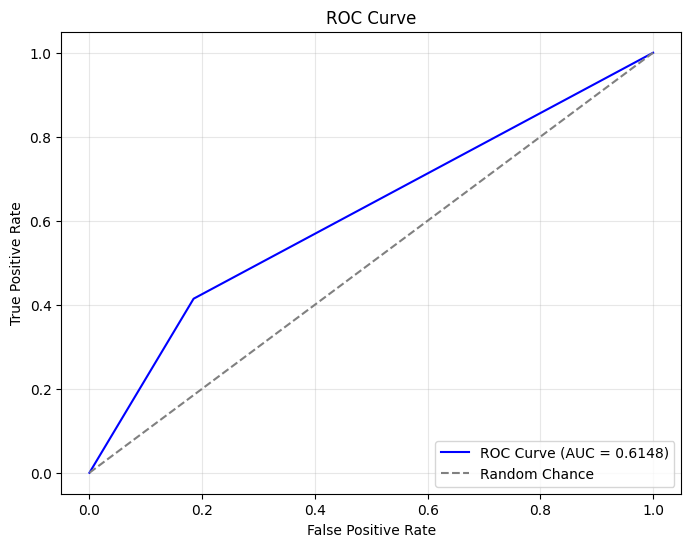

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve
# Calculate AUC
test_auc = roc_auc_score(y_test, test_predictions)
print(f"AUC on Test Dataset: {test_auc:.4f}")

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [43]:
def remove_outliers_iqr(df, columns, factor=1.5):
    df_cleaned = df.copy()  # Make a copy of the DataFrame to avoid modifying original data

    for column in columns:
        if column in df_cleaned.columns:
            Q1 = df_cleaned[column].quantile(0.25)  # 25th percentile
            Q3 = df_cleaned[column].quantile(0.75)  # 75th percentile
            IQR = Q3 - Q1

            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR

            # Filter rows within the IQR bounds
            df_cleaned[column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)

        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")

    return df_cleaned

In [44]:
from torch.utils.data import DataLoader, TensorDataset

In [45]:

test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/testing_loan_data.csv")

<ipython-input-45-57f9f7af733e>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/testing_loan_data.csv")


In [46]:
def preprocess_test_data(test_data, scaler, numer):
    """
    Preprocess the test dataset by performing cleaning, encoding, and scaling operations.

    Parameters:
    - test_data (pd.DataFrame): The raw test dataset.
    - scaler (sklearn.preprocessing.StandardScaler): Fitted scaler for numerical feature scaling.
    - numer (list): List of numerical column names.

    Returns:
    - pd.DataFrame: Preprocessed and scaled test dataset.
    """
    # Drop unnecessary columns
    miscol = ['id', 'application_approved_flag', 'tot_hi_cred_lim', 'revol_util',
              'loan_amnt', 'bc_util', 'desc', 'member_id', 'mths_since_last_major_derog']
    test_data.drop(miscol, axis=1, inplace=True, errors='ignore')

    # Process 'term' column
    test_data['term'] = test_data['term'].str.extract(r'(\d+)').astype(float)

    # Process 'emp_length' column
    test_data['emp_length'] = test_data['emp_length'].str.extract(r'(\d+)').astype(float)
    test_data['emp_length'] = test_data['emp_length'].fillna(0)  # Assume missing values as 0 (less than a year)

    # Process percentage columns
    percentage_columns = ['int_rate']
    for col in percentage_columns:
        if col in test_data.columns and test_data[col].dtype == 'object':
            test_data[col] = test_data[col].str.replace('%', '').astype(float) / 100

    # Fill missing values
    test_data['mths_since_recent_inq'] = test_data['mths_since_recent_inq'].fillna(0)

    columns_to_impute = ['percent_bc_gt_75', 'total_bc_limit', 'tot_cur_bal']
    for col in columns_to_impute:
        test_data[col] = test_data[col].fillna(test_data[col].median())

    # Handle categorical variables
    test_data['home_ownership'] = test_data['home_ownership'].replace(['OTHER', 'NONE'], 'OTHER')
    categorical_columns = ['purpose', 'home_ownership']
    test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns, drop_first=False, dtype=int)

    # Remove outliers
    columns_to_check = ['term', 'int_rate', 'emp_length', 'annual_inc', 'percent_bc_gt_75',
                        'dti', 'inq_last_6mths', 'mths_since_recent_inq',
                        'total_bc_limit', 'tot_cur_bal', 'internal_score']
    cleaned_data = remove_outliers_iqr(test_data_encoded, columns_to_check)

    # Scale numerical columns
    dummy = cleaned_data.columns.difference(numer)
    cleaned_data_num_scaled = scaler.transform(cleaned_data[numer])
    cleaned_data_scaled1 = pd.DataFrame(cleaned_data_num_scaled, columns=numer, index=cleaned_data.index)
    cleaned_data_scaled = pd.concat([cleaned_data_scaled1, cleaned_data[dummy]], axis=1)

    return cleaned_data_scaled

In [47]:
processed_test_data = preprocess_test_data(test_data, scaler, numer)

In [48]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(processed_test_data.values, dtype=torch.float32)

# Create DataLoader for batch processing
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=32, shuffle=False)

In [49]:
all_predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0]  # Extract inputs from TensorDataset
        outputs = model(inputs).squeeze()  # Forward pass
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities

        # Apply the best threshold
        predictions = (probabilities > best_threshold).int()

        all_predictions.extend(predictions.tolist())

# Insert predictions into the test dataset
test_data["bad_flag"] = all_predictions

# Save the updated test dataset
# test_data.to_csv("/content/drive/My Drive/Colab Notebooks/test_predictions_filled.csv", index=False)

print("Predictions saved successfully!")

Predictions saved successfully!
